In [1]:
import json
import os
import torch
import random
from collections import OrderedDict
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import torch
import random
import torchvision.transforms.functional as FT
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.nn.functional as F
from math import sqrt
from itertools import product as product
import torchvision
import torch
import json
import os
from PIL import Image
import torch
from collections import OrderedDict,defaultdict
import pandas as pd
import torch.backends.cudnn as cudnn
import wandb
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [4]:
random.seed(42)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare Label-to-int & Int-to-label Dictionaries
all_labels = []
all_labels_df=pd.read_csv("./lisa-traffic-sign/allAnnotations.csv",sep=';')
all_labels_df['Annotation tag'].value_counts()
# print(set(all_labels_df['Annotation tag']))
label_to_int = OrderedDict({label: num for num, label in enumerate(set(all_labels_df['Annotation tag']), start=1)})
label_to_int['background'] = 0
int_to_label = {v: k for k, v in label_to_int .items()}
int_to_label= OrderedDict(sorted(int_to_label.items(), key=lambda t: t[0]))
print(int_to_label)

def train_valid_test(directory,label_to_int):
    """
    split the dataset in the given path into three subsets(test,validation,train)
    :param path_to_dataset:
    :param train_ratio:
    :param valid_ratio:
    :return:
    """
    data_dict = {}
    
    for root,subdirectories,files in os.walk(directory):
        for subdirectory in subdirectories:
            if subdirectory.endswith('annotations'):
                # the initial entire dataset
                annotatios_file = glob.glob(os.path.join(os.path.join(root,subdirectory),'*tations.csv'))
#                 print(os.path.join(os.path.join(root,subdirectory)))
                anno_data_frame = pd.read_csv(annotatios_file[0],sep=';')

                
                for i, row in anno_data_frame.iterrows():
                    file, label, Upper_left_corner_X, Upper_left_corner_Y, Lower_right_corner_X, Lower_right_corner_Y, *_ = row
                    file=os.path.join(os.path.join(root,subdirectory),file)
            #         print(file)
                    if file not in data_dict:
                        boxes = list()
                        labels = list()
                        data_dict[file] = {"boxes": boxes, "labels": labels}


                        # images.append(file)
                        boxes.append([Upper_left_corner_X, Upper_left_corner_Y, Lower_right_corner_X, Lower_right_corner_Y])
                        labels.append(label_to_int[label])

                        data_dict[file]["boxes"] = boxes
                        data_dict[file]["labels"] = labels
                    else:
                        data_dict[file]["boxes"].append([Upper_left_corner_X, Upper_left_corner_Y, Lower_right_corner_X, Lower_right_corner_Y])
                        data_dict[file]["labels"].append(label_to_int[label])
                    # print(data_dict)

    #     print(len(data_dict))
    X = list(data_dict.keys())
    y = list(data_dict.values())
#     print(y)
    star_y = [l["labels"][0] for l in y]
#     print(star_y)
    
    X_train, X_dev_test, y_train, y_dev_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=star_y)
    star_y_dev_test = [l["labels"][0] for l in y_dev_test]
    X_test, X_valid, y_test, y_valid= train_test_split(X_dev_test, y_dev_test, test_size=0.50, random_state=42)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


directory='./lisa-traffic-sign'
X_train, X_valid, X_test, Y_train, Y_valid, Y_test=train_valid_test(directory, label_to_int)
     

print(len(X_train), len(X_valid), len(X_test))

#Train
output_folder = "./"
with open(os.path.join(output_folder, 'TRAIN_images.json'), 'w') as j:
    json.dump(X_train, j)
with open(os.path.join(output_folder, 'TRAIN_objects.json'), 'w') as j:
    json.dump(Y_train, j)
with open(os.path.join(output_folder, 'label_map.json'), 'w') as j:
    json.dump(label_to_int, j)  # save label map too
# Validation

with open(os.path.join(output_folder, 'VALIDATION_images.json'), 'w') as j:
    json.dump(X_valid, j)
with open(os.path.join(output_folder, 'VALIDATION_objects.json'), 'w') as j:
    json.dump(Y_valid, j)
# Test
with open(os.path.join(output_folder, 'TEST_images.json'), 'w') as j:
    json.dump(X_test, j)
with open(os.path.join(output_folder, 'TEST_objects.json'), 'w') as j:
    json.dump(Y_test, j)

OrderedDict([(0, 'background'), (1, 'slow'), (2, 'rampSpeedAdvisory40'), (3, 'zoneAhead45'), (4, 'speedLimit40'), (5, 'intersection'), (6, 'stopAhead'), (7, 'dip'), (8, 'thruTrafficMergeLeft'), (9, 'speedLimit50'), (10, 'rightLaneMustTurn'), (11, 'rampSpeedAdvisory45'), (12, 'merge'), (13, 'rampSpeedAdvisoryUrdbl'), (14, 'thruMergeLeft'), (15, 'noRightTurn'), (16, 'doNotEnter'), (17, 'keepRight'), (18, 'speedLimit35'), (19, 'yieldAhead'), (20, 'speedLimit65'), (21, 'noLeftTurn'), (22, 'rampSpeedAdvisory20'), (23, 'rampSpeedAdvisory35'), (24, 'schoolSpeedLimit25'), (25, 'speedLimit55'), (26, 'school'), (27, 'truckSpeedLimit55'), (28, 'speedLimit25'), (29, 'thruMergeRight'), (30, 'stop'), (31, 'curveRight'), (32, 'doNotPass'), (33, 'speedLimit45'), (34, 'curveLeft'), (35, 'laneEnds'), (36, 'zoneAhead25'), (37, 'turnLeft'), (38, 'speedLimit15'), (39, 'signalAhead'), (40, 'speedLimit30'), (41, 'yield'), (42, 'turnRight'), (43, 'addedLane'), (44, 'roundabout'), (45, 'speedLimitUrdbl'), (46,

In [2]:
def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.
    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.
    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor


def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).
    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).
    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.
    In the model, we are predicting bounding box coordinates in this encoded form.
    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.
    They are decoded into center-size coordinates.
    This is the inverse of the function above.
    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h


def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)


# Some augmentation functions below have been adapted from
# https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py

def random_crop(image, boxes, labels):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum overlap
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels

        # Try up to 50 times for this choice of minimum overlap
        # This isn't mentioned in the paper, of course, but 50 is chosen in paper authors' original Caffe repo
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0),
                                           boxes)  # (1, n_objects), n_objects is the no. of objects in this image
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels


def resize(image, boxes, dims=(600, 600), return_percent_coords=True):
    """
    Resize image.
    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes = boxes / old_dims  # percent coordinates

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes


def photometric_distort(image):
    """
    Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.
    :param image: image, a PIL Image
    :return: distorted image
    """
    new_image = image

    distortions = [FT.adjust_brightness,
                   FT.adjust_contrast,
                   FT.adjust_saturation,
                   FT.adjust_hue]

    random.shuffle(distortions)

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is 'adjust_hue':
                # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:
                # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
                adjust_factor = random.uniform(0.5, 1.5)

            # Apply this distortion
            new_image = d(new_image, adjust_factor)

    return new_image


def transform(image, boxes, labels, split):
    """
    Apply the transformations above.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param split: one of 'TRAIN' or 'TEST', since different sets of transformations are applied
    :return: transformed image, transformed bounding box coordinates, transformed labels
    """
    assert split in {'TRAIN', 'TEST','VALIDATION'}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    new_image = image
    new_boxes = boxes
    new_labels = labels
    
    # Skip the following operations for evaluation/testing
    if split == 'TRAIN':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)

        # Randomly crop image (zoom in)
        new_image, new_boxes, new_labels = random_crop(new_image, new_boxes, new_labels)

        # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)
        
        

    # Resize image to (600, 600) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes)

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)

    return new_image, new_boxes, new_labels


def adjust_learning_rate(optimizer, lr):
    """
    Scale learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param lr: new learning rate.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("Decaying learning rate.\n The new learning rate is %f\n" % (optimizer.param_groups[1]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)


def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename ='./checkpoint.pth.tar'
    
    
    
    
    torch.save(state, filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('loss.png')

In [3]:
class SSD600(nn.Module):
    """
    The SSD600 network - containing the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD600, self).__init__()

        self.n_classes = n_classes

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

        # Since lower level features (conv3_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors3_3 = nn.Parameter(torch.FloatTensor(1, 256, 1, 1))  # there are 256 channels in conv3_3_feats
        nn.init.constant_(self.rescale_factors3_3, 20)
        self.rescale_factors4_3 = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors4_3, 20)

        
        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        # Initialize convolutions' parameters
        nn.init.xavier_uniform_(self.conv8_1.weight)
        nn.init.constant_(self.conv8_1.bias, 0.)
        nn.init.xavier_uniform_(self.conv8_2.weight)
        nn.init.constant_(self.conv8_2.bias, 0.)

        
        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv3_3': 4,
                   'conv4_3': 4,
                   'conv7': 4,
                   'conv8_2': 4}

        # 4 prior boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv3_3 = nn.Conv2d(256, n_boxes['conv3_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv3_3 = nn.Conv2d(256, n_boxes['conv3_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        nn.init.xavier_uniform_(self.loc_conv3_3.weight)
        nn.init.constant_(self.loc_conv3_3.bias, 0.)
        nn.init.xavier_uniform_(self.loc_conv4_3.weight)
        nn.init.constant_(self.loc_conv4_3.bias, 0.)
        nn.init.xavier_uniform_(self.loc_conv7.weight)
        nn.init.constant_(self.loc_conv7.bias, 0.)
        nn.init.xavier_uniform_(self.loc_conv8_2.weight)
        nn.init.constant_(self.loc_conv8_2.bias, 0.)

        nn.init.xavier_uniform_(self.cl_conv3_3.weight)
        nn.init.constant_(self.cl_conv3_3.bias, 0.)
        nn.init.xavier_uniform_(self.cl_conv4_3.weight)
        nn.init.constant_(self.cl_conv4_3.bias, 0.)
        nn.init.xavier_uniform_(self.cl_conv7.weight)
        nn.init.constant_(self.cl_conv7.bias, 0.)
        nn.init.xavier_uniform_(self.cl_conv8_2.weight)
        nn.init.constant_(self.cl_conv8_2.bias, 0.)


        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def load_pretrained_layers(self):
        """
        We use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())
        
        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")


    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 600, 600)
        :return: 119720 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        out = F.relu(self.conv1_1(image))  # (N, 64, 600, 600)
        out = F.relu(self.conv1_2(out))  # (N, 64, 600, 600)
        out = self.pool1(out)  # (N, 64, 300, 300)

        out = F.relu(self.conv2_1(out))  # (N, 128, 300, 300)
        out = F.relu(self.conv2_2(out))  # (N, 128, 300, 300)
        out = self.pool2(out)  # (N, 128, 150, 150)

        out = F.relu(self.conv3_1(out))  # (N, 256, 150, 150)
        out = F.relu(self.conv3_2(out))  # (N, 256, 150, 150)
        out = F.relu(self.conv3_3(out))  # (N, 256, 150, 150)
        conv3_3_feats = out  # (N, 512, 150, 150)
        out = self.pool3(out)  # (N, 256, 75, 75)

        out = F.relu(self.conv4_1(out))  # (N, 512, 75, 75)
        out = F.relu(self.conv4_2(out))  # (N, 512, 75, 75)
        out = F.relu(self.conv4_3(out))  # (N, 512, 75, 75)
        conv4_3_feats = out  # (N, 512, 75, 75)
        out = self.pool4(out)  # (N, 512, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv5_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv5_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv5_3(out))  # (N, 512, 38, 38)
        out = self.pool5(out)  # (N, 512, 38, 38), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 38, 38)

        out = F.relu(self.conv7(out))  # (N, 1024, 38, 38)
        conv7_feats = out
        
        # Rescale conv3_3 after L2 norm
        norm = conv3_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 150, 150)
        conv3_3_feats = conv3_3_feats / norm  # (N, 512, 150, 150)
        conv3_3_feats = conv3_3_feats * self.rescale_factors3_3  # (N, 512, 150, 150)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 75, 75)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 75, 75)
        conv4_3_feats = conv4_3_feats * self.rescale_factors4_3  # (N, 512, 75, 75)

        
        # Run auxiliary convolutions (higher level feature map generators)
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 38, 38)
        out = F.relu(self.conv8_2(out))  # (N, 512, 19, 19)
        conv8_2_feats = out  # (N, 512, 19, 19)

        
        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        batch_size = conv3_3_feats.size(0)
        
        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv3_3 = self.loc_conv3_3(conv3_3_feats)  # (N, 16, 150, 150)
        l_conv3_3 = l_conv3_3.permute(0, 2, 3, 1).contiguous()  # (N, 150, 150, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv3_3 = l_conv3_3.view(batch_size, -1, 4)  # (N, 90000, 4), there are a total 90000 boxes on this feature map

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 75, 75)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()  # (N, 75, 75, 16), to match prior-box order (after .view())
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 22500, 4), there are a total 22500 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 16, 38, 38)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 38, 38, 16)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 16, 19, 19)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 16)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 1444, 4), there are a total 1444 boxes on this feature map


        # Predict classes in localization boxes
        c_conv3_3 = self.cl_conv3_3(conv3_3_feats)  # (N, 4 * n_classes, 150, 150)
        c_conv3_3 = c_conv3_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 150, 150, 4 * n_classes), to match prior-box order (after .view())
        c_conv3_3 = c_conv3_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 90000, n_classes), there are a total 90000 boxes on this feature map

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 75, 75)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 75, 75, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 22500, n_classes), there are a total 22500 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 38, 38, 4 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 4 * n_classes, 19, 19)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 4 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 1444, n_classes), there are a total 1444 boxes on this feature map


        # A total of 119720 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv3_3, l_conv4_3, l_conv7, l_conv8_2 ], dim=1) # (N, 119720, 4)
        classes_scores = torch.cat([c_conv3_3, c_conv4_3, c_conv7, c_conv8_2 ], dim=1)  # (N, 119720, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 119720 prior (default) boxes for the SSD600.
        :return: prior boxes in center-size coordinates, a tensor of dimensions (119720, 4)
        """
        fmap_dims = {'conv3_3': 150,
                     'conv4_3': 75,
                     'conv7': 38,
                     'conv8_2': 19}

        # small objects only
        obj_scales = {'conv3_3': 0.04, 
                      'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375}

        # near-square aspect ratios only
        aspect_ratios = {'conv3_3': [0.5, 0.6, 0.7],
                         'conv4_3': [0.5, 0.6, 0.7],
                         'conv7': [0.5, 0.6, 0.7],
                         'conv8_2': [0.5, 0.6, 0.7]}


        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 0.6, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 0.6:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (119720, 4)
        prior_boxes.clamp_(0, 1)  # (119720, 4)

        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 119720 locations and class scores (output of ths SSD600) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 119720 prior boxes, a tensor of dimensions (N, 119720, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 119720, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 119720, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (119720, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (119720)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (119720)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 119720
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.bool).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == True:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = False

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[~suppress])
                image_labels.append(torch.LongTensor((~suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[~suppress])
            
            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # remove multiple class suggestions for the same object    
            image_boxes, image_scores, image_labels = self.remove_duplicates(image_boxes, image_scores, image_labels, max_overlap)
            
            
            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size
    
    def remove_duplicates(self, image_boxes, image_scores, image_labels, max_overlap):
        """
        :param image_boxes: the boxes in an image
        :param image_scores: the scores of the boxes
        :param image_labels: the labels of the boxes
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed here
        :return: the unsuppressed boxes with scores and labels
        """
        suppress = torch.zeros((image_scores.shape[0]), dtype=torch.bool).to(device)
        for i in range(image_scores.shape[0]):
            for j in range(image_scores.shape[0]):
                if i == j:
                    continue
                if find_jaccard_overlap(image_boxes[i].unsqueeze(0), image_boxes[j].unsqueeze(0)) > max_overlap:
                    suppress[i if image_scores[i] < image_scores[j] else j] = True
                    return self.remove_duplicates(image_boxes[~suppress], image_scores[~suppress], image_labels[~suppress], max_overlap)
                    
        return image_boxes, image_scores, image_labels


class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction ='none')

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 119720 prior boxes, a tensor of dimensions (N, 119720, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 119720, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)
        
        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 119720, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 119720)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 119720)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (119720)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (119720)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (119720)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (119720, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 119720)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 119720)
        # So, if predicted_locs has the shape (N, 119720, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 119720)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 119720)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 119720)
        conf_loss_neg[positive_priors] = 0.  # (N, 119720), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 119720), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 119720)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 119720)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS
                
        return conf_loss + self.alpha * loc_loss

In [4]:
class LISADataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        """
        self.split = split.upper()
        # print('splut',self.split)

        assert self.split in {'TRAIN', 'TEST','VALIDATION'}

        self.data_folder = data_folder

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
#         print(os.getcwd())
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)


        # Apply transformations
        image, boxes, labels = transform(image, boxes, labels, split=self.split)

        return image, boxes, labels

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from _getitem_()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, and labels
        """

        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 600, 600), 2 lists of N tensors each

In [8]:


wandb_args = dict(
    api_key = 'dd3718ea0cc7a1c78b861f18150631f9fe2856c8',       # Your API Key (access from settings)
    entity = 'rahaf-abu-hara',        # Your W&B username
    project = 'Perception Project_5',
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
# Feel free to leave some out if you wish
config = dict(
    lr =  3e-4, wt = 5e-4,
    epochs = 30,decay_lr = {10:3e-5,15:3e-6,20:3e-7},
    momentum = 0.9 ,batch_size=4
)




#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)
#"cuda:0" if torch.cuda.is_available() else
torch.cuda.empty_cache()

def train(data_loader, model, criterion, optimizer, epoch,loss_history):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
 
    
    for phase in ['train','valid']:
        if phase == 'train':
                model.train()
        else:
                model.eval()
        losses = AverageMeter()  # loss
        
        # Batches
        # for i, (images, boxes, labels) in enumerate(data_loader[phase]):
        for i, (images, boxes, labels) in enumerate(data_loader[phase]):

            # Move to default device
            images = images.to(device)  # (batch_size (N), 3, 600, 600)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward prop.
            predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

            # backward + optimize only if in training phase
            if phase== 'train':
                loss.backward()
                # Update model
                optimizer.step()

            losses.update(loss.item(), images.size(0))
            if i % 100 == 0:
                print(losses.avg)
#             print(i)
        loss_history[phase]=losses.avg
#     print(1)

    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    return loss_history

# Data parameters
data_folder ='./'  # folder with data files

# Model parameters
n_classes = len(label_to_int)  # number of different types of objects
# Learning parameters
checkpoint = "./checkpoint.pth.tar" #   # path to model checkpoint, None if none
batch_size =config['batch_size']  # batch size
epochs = config['epochs']  # number of epochs to train
workers = 0  # number of workers for loading data in the DataLoader
print_freq = 100  # print training status every __ batches, 0: print only after every epoch
lr =config['lr'] # learning rate
decay_lr = config['decay_lr']  # decay learning rate after these many epochs
momentum =config['momentum']  # momentum
weight_decay= config['wt'] # weight decay
cudnn.benchmark = True

def main():
    """
    Training.
    """
    global start_epoch, epoch, checkpoint, decay_lr

    # Initialize model or load checkpoint
    if checkpoint is None:
        
        # delete the old log file
        # if os.path.exists("./train.log"):
        #     os.remove("./train.log")
        
        start_epoch = 0
        model = SSD600(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
    train_dataset = LISADataset(data_folder,
                                split='train')

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                                            collate_fn=train_dataset.collate_fn, num_workers=workers,
                                            pin_memory=True)  # note that we're passing the collate function here
    valid_dataset = LISADataset(data_folder,
                                split='validation')

    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,
                                            collate_fn=train_dataset.collate_fn, num_workers=workers,
                                            pin_memory=True)  # note that we're passing the collate function here
    dataloaders={'train':train_loader,'valid':valid_loader}

    loss_history = defaultdict()

    # Epochs
    for epoch in range(start_epoch, epochs):
    # Decay learning rate at particular epochs
        if epoch in decay_lr.keys():
            adjust_learning_rate(optimizer, decay_lr[epoch])

        # One epoch's training
        loss_history = train(data_loader=dataloaders,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    epoch=epoch,loss_history=loss_history)
    
        if print_freq == 0:
            for key,value in loss_history.items():
                wandb_logger.log({
                    key+'_loss': value,
                }, step=epoch)
                print('{} Loss: {:.4f}'.format(key.capitalize(), value))
                train_log = open('./train.log', 'a')
                train_log.write('{} Loss: {:.4f}'.format(key.capitalize(), value))
                train_log.close()


        # Save checkpoint
        if True:
            save_checkpoint(epoch, model, optimizer)
    return loss_history,model
history,model=main()
wandb_logger.finish()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: rahaf-abu-hara (use `wandb login --relogin` to force relogin)
c:\Users\Hossa\miniconda3\envs\torch\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
wandb: wandb version 0.12.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Loaded checkpoint from epoch 3.



NameError: name 'cxcy_to_xy' is not defined

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(15,15)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % (p)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)

In [34]:
import pickle

def save_to_pickle(path, item):
    """
    Function that saves an item to pickle file
    """
    with open(path, mode='wb') as f:
        pickle.dump(item, f)


def load_from_pickle(path):
    """
    Function that loads an item from pickle file
    """
    with open(path, 'rb') as f:
        return pickle.load(f)


Loaded checkpoint from epoch 25.

Lists Lengths 1560 1560
[30, 43, 46, 5, 12, 22, 40, 42, 18, 39, 38, 31, 45, 20, 29, 8, 7, 26, 41, 37, 11, 10, 28, 19, 15, 3, 32, 2, 34, 6, 44, 35, 14, 17, 27, 16, 25, 1, 33, 9, 36, 23, 47, 21, 13, 24, 4]
[39, 22, 11, 18, 18, 43, 5, 30, 39, 42, 43, 5, 6, 34, 37, 46, 46, 41, 22, 43, 43, 43, 30, 19, 30, 19, 22, 18, 43, 30, 30, 5, 22, 42, 5, 43, 5, 29, 22, 30, 46, 30, 43, 19, 5, 19, 5, 40, 35, 46, 42, 39, 40, 43, 35, 46, 5, 31, 31, 30, 17, 32, 30, 30, 46, 46, 46, 30, 26, 40, 43, 33, 30, 32, 5, 29, 43, 39, 20, 46, 43, 46, 46, 31, 30, 30, 30, 12, 43, 45, 46, 43, 46, 38, 43, 5, 30, 12, 12, 43, 5, 7, 30, 30, 40, 25, 46, 46, 22, 40, 30, 30, 38, 30, 2, 11, 43, 43, 43, 42, 46, 12, 30, 30, 30, 46, 46, 18, 43, 22, 46, 44, 43, 12, 42, 5, 5, 12, 12, 12, 32, 32, 12, 37, 3, 22, 12, 11, 10, 40, 30, 22, 45, 10, 43, 5, 5, 43, 40, 26, 43, 19, 38, 43, 43, 43, 46, 46, 38, 43, 30, 46, 12, 43, 46, 46, 22, 26, 46, 46, 43, 5, 26, 12, 43, 30, 8, 46, 46, 14, 14, 30, 38, 42, 11, 4

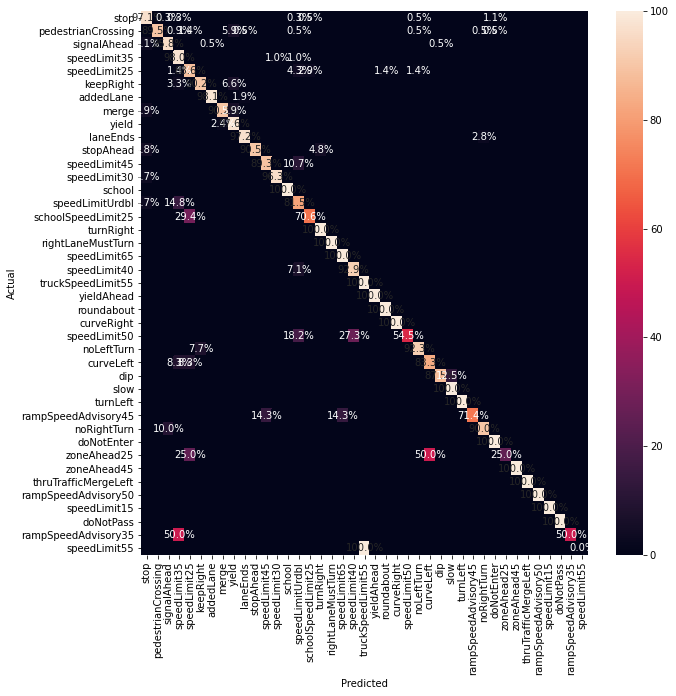

In [36]:
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
import re

device = "cuda"

all_labels = []
all_labels_df=pd.read_csv("./lisa-traffic-sign/allAnnotations.csv",sep=';')
all_labels_df['Annotation tag'].value_counts()
for_cm = list(all_labels_df['Annotation tag'].value_counts().keys())
# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

# Data parameters
data_folder = './'  # folder with data files

# Load model checkpoint
checkpoint = './kaggle_checkpoints/checkpoint.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

with open('./kaggle_checkpoints/label_map.json', 'r') as j:
    label_to_int = json.load(j)
    
int_to_label = {v: k for k, v in label_to_int .items()}
# Transforms
resize = transforms.Resize((600,600))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
all_results = {}
results = {}
for label in set(all_labels_df['Annotation tag']):
    results[label] = {}
    results[label]['true_positive'] = 0
    results[label]['false_positive'] = 0
    results[label]['false_negative'] = 0

all_results['true_positive'] = 0
all_results['false_positive'] = 0
all_results['false_negative'] = 0

def box_match(box_1, label_1, box_2, label_2, max_overlap=0.3):
    """
    Determines whether two boxes overlap themselves and have the same label
    :param box_1: the first box
    :param label_1: the label of the first box
    :param box_2: the second box
    :param label_2: the label of the second box
    :param max_overlap: threshold value for determining whether two boxes overlap themselves
    :return: boolean value indicating whether the boxes overlap themselves and have the same label
    """
    return find_jaccard_overlap(box_1.unsqueeze(0), box_2.unsqueeze(0)) > max_overlap and label_1 == label_2

def my_evaluate(img,original_image, img_id, annotations, cm_det_labels, cm_true_labels, min_score=0.45, max_overlap=0.3, top_k=200, annotate_image=True):
# def my_evaluate(img,original_image, img_id, annotations, min_score=0.45, max_overlap=0.3, top_k=200, annotate_image=True,):
    """
    Detect objects in an image with a trained SSD600, and visualize the results.
    :param original_image: image, a PIL Image
    :param img_id: the identifier of the image, used as file name
    :param annotations: ground truth information on the traffic signs in the image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param annotate_image: boolean variable indicating whether annotated images shall be written to a file
    """

    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)
#     print(image.shape)

    # Forward prop. # Add a batch dimension:
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
#     print( predicted_locs.shape)
    # Detect objects in SSD output
    import time
    tic = time.time()
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,max_overlap=max_overlap, top_k=top_k)
    toc = time.time()
    inference_time = toc-tic
    # print("Inference time", toc-tic)
    
    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [int_to_label[l] for l in det_labels[0].to('cpu').tolist()]
    det_scores = det_scores[0].to('cpu').tolist()
    
    
    # Annotate
    annotated_image = original_image

    if det_labels != ['background']:
        for i in range(det_boxes.size(0)):
            
            # Create an image showing the detected traffic signs, if requested
            if annotate_image:
                draw = ImageDraw.Draw(annotated_image)
                font = ImageFont.load_default()

                # Boxes
                box_location = det_boxes[i].tolist()
                draw.rectangle(xy=box_location, outline='#ff0000')
                draw.rectangle(xy=[l + 1. for l in box_location], outline='#ff0000')  # a second rectangle at an offset of 1 pixel to increase line thickness

                # Text
                text = det_labels[i].upper() + ' ' + str(det_scores[i])
                text_size = font.getsize(text)
                text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
                textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                                    box_location[1]]
                draw.rectangle(xy=textbox_location, fill='#ff0000')
                draw.text(xy=text_location, text=text, fill='white', font=font)

                del draw
            
            # For every detection, see whether it matches a ground truth
            match = False
            for j in range(len(annotations['boxes'])):
                if annotations['labels'][j] == -1: # this is being set when a ground truth already matched
                    continue
                match = box_match(det_boxes[i], 
                                  det_labels[i], 
                                  torch.Tensor(annotations['boxes'][j]), 
                                  int_to_label[annotations['labels'][j]])
                
               
                cm_det_labels.append(det_labels[i])
                cm_true_labels.append(int_to_label[annotations['labels'][j]])
                
                if match:
                    annotations['labels'][j] = -1
                    break
            
            if match: # true positive if the detection is correct and matched a ground truth
                all_results['true_positive'] += 1
                results[det_labels[i]]['true_positive'] += 1
            else: # false positive if the detection did not match a ground truth
                all_results['false_positive'] += 1
                results[det_labels[i]]['false_positive'] += 1
        
        if annotate_image:
            annotated_image.save('./' + img_id + '.png')


    # After all detections were checked, let us see whether the detector missed something
    for label in annotations['labels']: 
        if label == -1: # This is set after a detection matched this ground truth
            continue
        
        # false negative if we reach this line, since the ground truth object was not found
        results[int_to_label[label]]['false_negative'] += 1 
        all_results['false_negative'] += 1
    return cm_det_labels, cm_true_labels, inference_time

def removeprefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  


# Find IDs of images in the test data
with open(os.path.join('./kaggle_checkpoints', 'TEST'+ '_images.json'), 'r') as j:
    images = json.load(j)
with open(os.path.join('./kaggle_checkpoints', 'TEST' + '_objects.json'), 'r') as j:
    objects = json.load(j)

cm_det_labels=[]
cm_true_labels=[]
all_inf = []


if not os.path.exists("./predictions.pickle"):
    # from tqdm import tqdm
    # for obj,img in tqdm(zip(objects,images), total=len(images), desc="Images"):
    for i, (obj,img) in enumerate(zip(objects,images)):
        #     print(img)
        annotations = obj
        original_image = Image.open(img, mode='r')
        original_image = original_image.convert('RGB')
        b=img.find('_annotations/',0)+13
        img_id=removeprefix(img,img[:b])
        img_id= re.sub('\.png$', '', img_id)
        allcm_det_label,allcm_true_label, inference_time =my_evaluate(img,original_image, img_id, annotations, cm_det_labels, cm_true_labels, annotate_image=True)
        all_inf.append(inference_time)
        if i % 100 == 0:
            print(i)
        # print(img)
        # print("det", det_label)
        # print("tru", true_label)
        # exit()
        # det_labels.append(det_label)
        # true_labels.append(true_label)

    # Calculate precisio and recall
    precision = {}
    recall = {}
    precision['ALL'] = all_results['true_positive'] / (all_results['true_positive'] + all_results['false_positive'])       
    recall['ALL'] = all_results['true_positive'] / (all_results['true_positive'] + all_results['false_negative'])

    for label in set(all_labels_df['Annotation tag']):
        # Precision
        if results[label]['true_positive'] + results[label]['false_positive'] > 0: # check for detections
            precision[label] = results[label]['true_positive'] / (results[label]['true_positive'] + results[label]['false_positive'])
        else:
            precision[label] = 'No detections'
            if results[label]['false_negative'] == 0:
                precision[label] = 'No detections, but also no signs in test set'

        # Recall
        if results[label]['true_positive'] + results[label]['false_negative'] > 0: # check for ground truth objects
            recall[label] = results[label]['true_positive'] / (results[label]['true_positive'] + results[label]['false_negative'])
        else:
            recall[label] = 'No signs in test set'

    # Print results
    print('PRECISION')
    pp.pprint(precision)
    print()
    print('RECALL')
    pp.pprint(recall)
    # f1_score = {}
    # for (pk, p), (rk, r) in zip(precision.items(), recall.items()):
    #     f1_score.update({pk: (2 * float(p) * float(r)) / (float(p) + float(r)) })

    # print('F1')
    # pp.pprint(f1_score)

    save_to_pickle("./predictions.pickle", allcm_det_label)
    save_to_pickle("./groundtruth.pickle", allcm_true_label)

else:
    allcm_det_label = load_from_pickle("./predictions.pickle")
    allcm_true_label = load_from_pickle("./groundtruth.pickle")


print("Lists Lengths", len(allcm_det_label), len(allcm_true_label))

# print("Average Inf. Time", sum(all_if) / len(all_inf) )
for_cm = [label_to_int[c] for c in for_cm]
print("before", for_cm)

allcm_det_label = [label_to_int[d] for d in allcm_det_label]
allcm_true_label = [label_to_int[t] for t in allcm_true_label]




for item in for_cm:
    if item not in allcm_true_label:
        for_cm.remove(item)

for item in for_cm:
    if item not in allcm_det_label:
        for_cm.remove(item)

print("after", for_cm)



print(allcm_det_label)
print()
print(allcm_true_label)



# print(allcm_det_label)
# print(allcm_true_label)
cm_analysis(allcm_true_label, allcm_det_label, "./ConfusionMatrix.jpg", for_cm, ymap=int_to_label, figsize=(10,10))
# cm = confusion_matrix(allcm_det_label, allcm_true_label, labels=all_labels_df['Annotation tag'])
# print(cm)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=all_labels_df['Annotation tag'])
# print(type(disp))
# disp.plot()
# # plt.show()
# plt.savefig("./cm.png")




In [ ]:
# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

# Data parameters
data_folder = './'  # folder with data files

# # Load model checkpoint
# checkpoint = '../input/check-batch1/checkpoint.pth (14).tar'
# checkpoint = torch.load(checkpoint)
# start_epoch = checkpoint['epoch'] + 1
# print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
# model = checkpoint['model']
model = model.to(device)
model.eval()

with open('./label_map.json', 'r') as j:
    label_to_int = json.load(j)
    
int_to_label = {v: k for k, v in label_to_int .items()}
# Transforms
resize = transforms.Resize((600,600))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
all_results = {}
results = {}
for label in set(all_labels_df['Annotation tag']):
    results[label] = {}
    results[label]['true_positive'] = 0
    results[label]['false_positive'] = 0
    results[label]['false_negative'] = 0

all_results['true_positive'] = 0
all_results['false_positive'] = 0
all_results['false_negative'] = 0

def box_match(box_1, label_1, box_2, label_2, max_overlap=0.3):
    """
    Determines whether two boxes overlap themselves and have the same label
    :param box_1: the first box
    :param label_1: the label of the first box
    :param box_2: the second box
    :param label_2: the label of the second box
    :param max_overlap: threshold value for determining whether two boxes overlap themselves
    :return: boolean value indicating whether the boxes overlap themselves and have the same label
    """
    return find_jaccard_overlap(box_1.unsqueeze(0), box_2.unsqueeze(0)) > max_overlap and label_1 == label_2

def my_evaluate(img,original_image, img_id, annotations, min_score=0.45, max_overlap=0.3, top_k=200, annotate_image=True):
    """
    Detect objects in an image with a trained SSD600, and visualize the results.
    :param original_image: image, a PIL Image
    :param img_id: the identifier of the image, used as file name
    :param annotations: ground truth information on the traffic signs in the image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param annotate_image: boolean variable indicating whether annotated images shall be written to a file
    """

    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)
#     print(image.shape)

    # Forward prop. # Add a batch dimension:
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
#     print( predicted_locs.shape)
    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,max_overlap=max_overlap, top_k=top_k)
    
    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [int_to_label[l] for l in det_labels[0].to('cpu').tolist()]
    det_scores = det_scores[0].to('cpu').tolist()
    
    
    # Annotate
    annotated_image = original_image

    if det_labels != ['background']:
        for i in range(det_boxes.size(0)):
            
            # Create an image showing the detected traffic signs, if requested
            if annotate_image:
                draw = ImageDraw.Draw(annotated_image)
                font = ImageFont.load_default()

                # Boxes
                box_location = det_boxes[i].tolist()
                draw.rectangle(xy=box_location, outline='#ff0000')
                draw.rectangle(xy=[l + 1. for l in box_location], outline='#ff0000')  # a second rectangle at an offset of 1 pixel to increase line thickness

                # Text
                text = det_labels[i].upper() + ' ' + str(det_scores[i])
                text_size = font.getsize(text)
                text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
                textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                                    box_location[1]]
                draw.rectangle(xy=textbox_location, fill='#ff0000')
                draw.text(xy=text_location, text=text, fill='white', font=font)

                del draw
            
            # For every detection, see whether it matches a ground truth
            match = False
            for j in range(len(annotations['boxes'])):
                if annotations['labels'][j] == -1: # this is being set when a ground truth already matched
                    continue
                match = box_match(det_boxes[i], 
                                  det_labels[i], 
                                  torch.Tensor(annotations['boxes'][j]), 
                                  int_to_label[annotations['labels'][j]])
                if match:
                    annotations['labels'][j] = -1
                    break
            
            if match: # true positive if the detection is correct and matched a ground truth
                all_results['true_positive'] += 1
                results[det_labels[i]]['true_positive'] += 1
            else: # false positive if the detection did not match a ground truth
                all_results['false_positive'] += 1
                results[det_labels[i]]['false_positive'] += 1
        
        if annotate_image:
            annotated_image.save('./' + img_id + '.png')


    # After all detections were checked, let us see whether the detector missed something
    for label in annotations['labels']: 
        if label == -1: # This is set after a detection matched this ground truth
            continue
        
        # false negative if we reach this line, since the ground truth object was not found
        results[int_to_label[label]]['false_negative'] += 1 
        all_results['false_negative'] += 1
    return 
def removeprefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  
# Find IDs of images in the test data
with open(os.path.join(data_folder, 'TEST'+ '_images.json'), 'r') as j:
    images = json.load(j)
with open(os.path.join(data_folder, 'TEST' + '_objects.json'), 'r') as j:
    objects = json.load(j)
    
for obj,img in zip(objects,images):
    #     print(img)
    annotations = obj
    original_image = Image.open(img, mode='r')
    original_image = original_image.convert('RGB')
    b=img.find('_annotations/',0)+13
    img_id=removeprefix(img,img[:b])
    img_id= re.sub('\.png$', '', img_id)
    my_evaluate(img,original_image, img_id, annotations, annotate_image=True)


# Calculate precisio and recall
precision = {}
recall = {}
precision['ALL'] = all_results['true_positive'] / (all_results['true_positive'] + all_results['false_positive'])       
recall['ALL'] = all_results['true_positive'] / (all_results['true_positive'] + all_results['false_negative'])

for label in set(all_labels_df['Annotation tag']):
    # Precision
    if results[label]['true_positive'] + results[label]['false_positive'] > 0: # check for detections
        precision[label] = results[label]['true_positive'] / (results[label]['true_positive'] + results[label]['false_positive'])
    else:
        precision[label] = 'No detections'
        if results[label]['false_negative'] == 0:
            precision[label] = 'No detections, but also no signs in test set'

    # Recall
    if results[label]['true_positive'] + results[label]['false_negative'] > 0: # check for ground truth objects
        recall[label] = results[label]['true_positive'] / (results[label]['true_positive'] + results[label]['false_negative'])
    else:
        recall[label] = 'No signs in test set'

# Print results
print('PRECISION')
pp.pprint(precision)
print()
print('RECALL')
pp.pprint(recall)